In [1]:
%run utils.ipynb
%run transformers.ipynb

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv("../data/train.csv")

#drop some useless columns
cols_to_drop=["Id","PID"]
df=df.drop(columns=cols_to_drop)

#drop outliers identified in part 1
df=df[df['Gr Liv Area']<=4500]
df=df[df['SalePrice']>np.expm1(10)]

df_copy=df.copy()

In [4]:
features_to_keep=['Gr Liv Area', 'Overall Qual', 'Year Built', 'Total Bsmt SF', 'Fireplace Qu',
 'BsmtFin SF 1', 'Overall Cond', 'Garage Cars', 'Functional', 'Year Remod/Add', 'Exter Qual',
 'Foundation_PConc', 'Garage Type_Attchd', 'Kitchen Qual', 'Garage Type_Detchd', 'Lot Frontage',
 'Lot Area']

In [5]:
cols_to_impute_with_none=["Pool QC","Misc Feature","Alley","Fence","Fireplace Qu",
                          "Garage Finish","Garage Qual","Garage Cond","Garage Type",
                         "Bsmt Exposure","BsmtFin Type 2","Bsmt Cond","Bsmt Qual","BsmtFin Type 1",
                         "Mas Vnr Type"]

cols_to_impute_with_zero=["Garage Yr Blt","Mas Vnr Area","Bsmt Full Bath","Bsmt Half Bath","Garage Area",
                         "Garage Cars","Total Bsmt SF","Bsmt Unf SF","BsmtFin SF 2","BsmtFin SF 1"]

cols_to_impute_with_mode=["Electrical"]

correlated_to_drop=["1st Flr SF","Garage Yr Blt","TotRms AbvGrd","Garage Area"]

In [6]:
#Create a regressor to dynamically creates a pipeline
def create_regressor(model,**kwargs):
    '''
    model: estimator instance
    return: TransformedTargetRegressor
    '''
    pipeline=Pipeline(steps=[
        ('drop_correlated',DropCorrelated(correlated_to_drop)),
        ('ms_subclass_convert',MSSubClassConvert()),
        ('standard_impute',StandardImpute(none=cols_to_impute_with_none,
                                          zero=cols_to_impute_with_zero,
                                          mode=cols_to_impute_with_mode)),
        ('lot_frotage_impute',LotFrontageImpute()),
        ('ordinal_to_numerical',OrdinalToNumeric()),
        ('onehotencode',OneHotEncode()),
        ('align_train_and_predict',AlignTrainPredict(**kwargs)), #This is to align the train and predict DF in case they are different
        ('passthrough',Passthrough()), #Passthrough step, does nothing. Only exists to allow external code to retrieve feature names.
        ('robustscalar',RobustScaler()),
        ('model',model)
    ])
    
    return TransformedTargetRegressor(regressor=pipeline,
                                    func=np.log1p,
                                    inverse_func=np.expm1
                                    )

In [7]:
#set up X and Y
X=df.drop(columns="SalePrice")
y=df["SalePrice"]

#make a backup copy
X_copy=X.copy()
y_copy=y.copy()

#### Without any regularization

In [8]:
#create regressor and instruct to keep only numerical features
reg=create_regressor(LinearRegression(),feature_names=features_to_keep)

grid = GridSearchCV(reg,cv=5,param_grid={'regressor__model__fit_intercept':[True]},
                    scoring='neg_root_mean_squared_error')
grid.fit(X,y)

display(-1*grid.best_score_)

24207.397640972507

#### With L1 regularization

In [11]:
L1_alpha=np.linspace(0,1,10)

#create regressor and instruct to keep only numerical features
reg=create_regressor(Lasso(),feature_names=features_to_keep)

grid = GridSearchCV(reg,param_grid={'regressor__model__alpha':L1_alpha},
                   cv=5,
                    scoring='neg_root_mean_squared_error',return_train_score=True)
grid.fit(X,y)

display(-1*grid.best_score_)
display(grid.best_params_)
display(pd.DataFrame(grid.cv_results_))

24207.397640972526

{'regressor__model__alpha': 0.0}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.089406,0.002503,0.045528,0.001093,0.0,{'regressor__model__alpha': 0.0},-24794.969790,-30483.879329,-21565.532563,-20554.244895,...,-24207.397641,3475.291109,1,-21497.888252,-22216.464138,-22512.897728,-22528.085157,-22063.663265,-22163.799708,377.044356
1,0.063417,0.001160,0.044089,0.000761,0.111111,{'regressor__model__alpha': 0.1111111111111111},-50391.275745,-48912.218613,-50556.906645,-48682.457787,...,-50949.419085,2733.788462,2,-50470.856300,-51276.993533,-50838.039358,-51987.287877,-49916.871303,-50898.009674,704.108616
2,0.065577,0.002576,0.047804,0.002044,0.222222,{'regressor__model__alpha': 0.2222222222222222},-76287.947086,-75376.952754,-79481.081619,-74497.462811,...,-77632.938007,2967.856542,3,-76976.662703,-78056.612571,-77500.998458,-79151.326202,-76323.182758,-77601.756539,963.712152
3,0.061997,0.000629,0.044000,0.000011,0.333333,{'regressor__model__alpha': 0.3333333333333333},-79658.164420,-78165.514339,-82273.586627,-76718.621996,...,-80418.860821,3046.417179,4,-80405.585224,-80951.573646,-80174.673335,-81383.743686,-79300.397564,-80443.194691,710.293607
4,0.064598,0.002329,0.045997,0.001415,0.444444,{'regressor__model__alpha': 0.4444444444444444},-79658.164420,-78165.514339,-82273.586627,-76718.621996,...,-80418.860821,3046.417179,4,-80405.585224,-80951.573646,-80174.673335,-81383.743686,-79300.397564,-80443.194691,710.293607
5,0.063170,0.000754,0.044402,0.000493,0.555556,{'regressor__model__alpha': 0.5555555555555556},-79658.164420,-78165.514339,-82273.586627,-76718.621996,...,-80418.860821,3046.417179,4,-80405.585224,-80951.573646,-80174.673335,-81383.743686,-79300.397564,-80443.194691,710.293607
6,0.063269,0.001693,0.044403,0.000482,0.666667,{'regressor__model__alpha': 0.6666666666666666},-79658.164420,-78165.514339,-82273.586627,-76718.621996,...,-80418.860821,3046.417179,4,-80405.585224,-80951.573646,-80174.673335,-81383.743686,-79300.397564,-80443.194691,710.293607
7,0.064598,0.002937,0.044999,0.000640,0.777778,{'regressor__model__alpha': 0.7777777777777777},-79658.164420,-78165.514339,-82273.586627,-76718.621996,...,-80418.860821,3046.417179,4,-80405.585224,-80951.573646,-80174.673335,-81383.743686,-79300.397564,-80443.194691,710.293607
8,0.064808,0.001475,0.045793,0.002403,0.888889,{'regressor__model__alpha': 0.8888888888888888},-79658.164420,-78165.514339,-82273.586627,-76718.621996,...,-80418.860821,3046.417179,4,-80405.585224,-80951.573646,-80174.673335,-81383.743686,-79300.397564,-80443.194691,710.293607
9,0.065327,0.002765,0.045400,0.001020,1.0,{'regressor__model__alpha': 1.0},-79658.164420,-78165.514339,-82273.586627,-76718.621996,...,-80418.860821,3046.417179,4,-80405.585224,-80951.573646,-80174.673335,-81383.743686,-79300.397564,-80443.194691,710.293607


Best L1 model is when $\alpha = 0$

#### With L2 regularization

In [10]:
L2_alpha=np.linspace(0,100,10)

#create regressor and instruct to keep only numerical features
reg=create_regressor(Lasso(),feature_names=features_to_keep)

grid = GridSearchCV(reg,param_grid={'regressor__model__alpha':L2_alpha},
                   cv=5,scoring='neg_root_mean_squared_error')
grid.fit(X,y)

display(-1*grid.best_score_)
display(grid.best_params_)

24207.397640972526

{'regressor__model__alpha': 0.0}

#### With Elastic Net regularization

It appears the best model is still the linear model where $\alpha =0$

### Let's look at the residual plot of the Linear Regression model.

In [18]:
from yellowbrick.regressor import ResidualsPlot

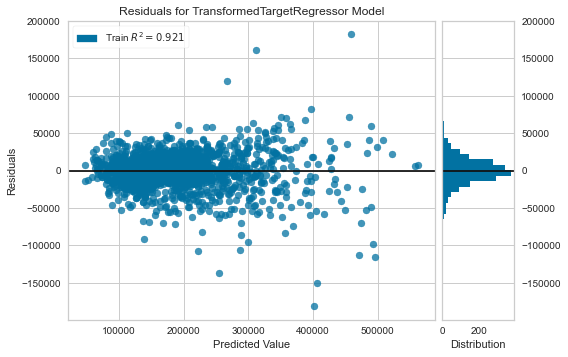

In [27]:
#create regressor and instruct to keep only numerical features
reg=create_regressor(LinearRegression(),feature_names=features_to_keep)

viz=ResidualsPlot(reg)
viz.fit(X,y)
ax=viz.show()

Looks normally distributed, and points are centred around 0.  
All is good!

In [50]:
reg=create_regressor(LinearRegression(),feature_names=features_to_keep)
reg.fit(X,y)
pred=reg.predict(X)

df_tp=pd.DataFrame([y,pred]).T.dropna()
df_tp.columns=["y_true","y_pred"]
df_tp

,y_true,y_pred
0,130500.0,191288.306659
1,220000.0,235394.341580
2,109000.0,138327.206437
3,174000.0,139965.528559
4,138500.0,140032.172398
...,...,...
2042,83000.0,288673.606859
2043,128000.0,97815.822465
2044,182000.0,148602.390908
2045,394617.0,120941.379641


In [51]:
fig=px.scatter(x=y,y=pred)
fig.show()

In [52]:
fig=px.scatter(df_tp,x='y_true',y='y_pred', width=1200,height=600,
              title="<b>Predicted SalePrice vs Actual SalePrice</b>",
              labels={
                  'y_true':"Actual Sale Price",
                  'y_pred':"Predicted Sale Price"
              })
fig.show()

### Try a submission

In [12]:
#Instantiate a copy of Tester helper class
tester=Tester("../data/test.csv")

In [13]:
#obtain a copy of the test set
df_test=tester.get_test_df()

In [14]:
#reset the df
X=X_copy.copy()

#instantiate and train the model using the entire dataset
lr=create_regressor(LinearRegression(),feature_names=features_to_keep)
lr.fit(X,y)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('drop_correlated',
                                                      DropCorrelated(drop=['1st '
                                                                           'Flr '
                                                                           'SF',
                                                                           'Garage '
                                                                           'Yr '
                                                                           'Blt',
                                                                           'TotRms '
                                                                           'AbvGrd',
                                                                           'Garage '
                                                                           'Area'])),
                                                     ('ms_subclass_convert',
                                                      MSSubClassConvert()),
                                                     ('standard_impute',
                                                      StandardImpute(mode=['Electrical'],
                                                                     none=['Pool '
                                                                           'QC',
                                                                           'Misc '
                                                                           'Feature',
                                                                           'Alley',
                                                                           'F...
                                                                                       'Qual',
                                                                                       'Year '
                                                                                       'Built',
                                                                                       'Total '
                                                                                       'Bsmt '
                                                                                       'SF',
                                                                                       'Fireplace '
                                                                                       'Qu',
                                                                                       'BsmtFin '
                                                                                       'SF '
                                                                                       '1',
                                                                                       'Overall '
                                                                                       'Cond',
                                                                                       'Garage '
                                                                                       'Cars',
                                                                                       'Functional',
                                                                                       'Year '
                                                                                       'Remod/Add',
                                                                                       'Exter '
                                                                                       'Qual',
                                                                                       'Foundation_PConc',
                                                                                       'Garage '
                                                                              

In [15]:
#make prediction
ypred=lr.predict(df_test)

In [16]:
tester.write_submission(ypred,"../data/05_final.csv")

Output saved to ../data/05_final.csv


**Results**  
Score:25366  
Private score: 23227